In [1]:
%load_ext autoreload
%autoreload 2

%cd -q ..

In [2]:
import os
from datetime import datetime

# DATA SCIENCE
import numpy as np
import pandas as pd

# PYTORCH
import torch
import torchvision
import torchvision.datasets as datasets

# PLOTLY
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# MATPLOTLIB
import matplotlib.pyplot as plt

# PROJECT
import base
from plots.images import plot_images_matplotlib, plot_images_plotly
from tensorutils import describe
from experiment import Experiment
from models.linear_regression import LinearRegression
from models.triple_dense import TripleDense
from data_loaders.transformations import ReshapeTransform

In [3]:
data_dir = base.DIR_DATA
batch_size = 256
loss_fn = torch.nn.CrossEntropyLoss()
# MEAN = 0.1307
# STD  = 0.3081
MEAN = 0.5
STD  = 0.5

transformations = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (MEAN,), (STD,)
        ),
        ReshapeTransform((-1,)),

    ]
)

train_dataset = datasets.MNIST(root=data_dir, train=True, transform=transformations)
test_dataset = datasets.MNIST(root=data_dir, train=False, transform=transformations)

data_shape = train_dataset.data.shape[1:]
x_dim = data_shape[0]*data_shape[0]
n_labels = len(train_dataset.classes)

# to use small dataset
# train_dataset, _ = torch.utils.data.random_split(train_dataset, [10000, 50000])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

In [4]:
hidden1 = 500
hidden2 = 300
model = TripleDense(x_dim, hidden1, hidden2, n_labels)

In [24]:
# device = 'cpu'
# device = 'cuda'
device = None
optimizer_class = torch.optim.Adagrad
experiment = Experiment(model, loss_fn, device=device, optimizer_class=optimizer_class)

In [25]:
# start = datetime.now()
# experiment.train_model(train_loader=train_loader, num_epochs=10, valid_loader=test_loader, validate_every=2)

# last = datetime.now() - start
# print("Lasted = {}".format(last))

In [34]:
targets = torch.arange(10, device='cuda')
start = datetime.now()
num_epochs = 2000
x_adv = experiment.train_adversarial(x_shape=(x_dim,), targets=targets, num_epochs=num_epochs, info_every=num_epochs//10)
last = datetime.now() - start
print("Lasted = {}".format(last))

TRAINING:    epoch:      0, loss=839.4858, acc=   0.00
TRAINING:    epoch:    200, loss=12.4387, acc=   1.00
TRAINING:    epoch:    400, loss= 2.3684, acc=   1.00
TRAINING:    epoch:    600, loss= 1.0561, acc=   1.00
TRAINING:    epoch:    800, loss= 0.8007, acc=   1.00
TRAINING:    epoch:   1000, loss= 0.7353, acc=   1.00
TRAINING:    epoch:   1200, loss= 0.7188, acc=   1.00
TRAINING:    epoch:   1400, loss= 0.7115, acc=   1.00
TRAINING:    epoch:   1600, loss= 0.7101, acc=   1.00
TRAINING:    epoch:   1800, loss= 0.7077, acc=   1.00
TRAINING:    epoch:   2000, loss= 0.7094, acc=   1.00
Lasted = 0:00:14.038057


In [35]:
data = x_adv.cpu().numpy().reshape(-1, 28, 28)
# vmax = 2
# data = data.clip(-vmax,vmax)
labels = targets.cpu().numpy()
probs = experiment.predict(x_adv)
probs = probs.detach().cpu().numpy()
probs.round(2)

array([[0.78, 0.06, 0.01, 0.  , 0.12, 0.  , 0.01, 0.  , 0.01, 0.  ],
       [0.03, 0.84, 0.01, 0.02, 0.03, 0.  , 0.01, 0.01, 0.02, 0.02],
       [0.01, 0.07, 0.76, 0.02, 0.06, 0.01, 0.01, 0.01, 0.05, 0.  ],
       [0.  , 0.01, 0.07, 0.69, 0.01, 0.03, 0.  , 0.02, 0.13, 0.05],
       [0.06, 0.01, 0.  , 0.  , 0.92, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.04, 0.05, 0.02, 0.04, 0.01, 0.6 , 0.03, 0.05, 0.11, 0.05],
       [0.03, 0.02, 0.06, 0.01, 0.04, 0.03, 0.66, 0.01, 0.1 , 0.03],
       [0.  , 0.03, 0.06, 0.06, 0.01, 0.01, 0.  , 0.79, 0.01, 0.02],
       [0.05, 0.01, 0.03, 0.05, 0.02, 0.04, 0.02, 0.01, 0.7 , 0.07],
       [0.03, 0.01, 0.02, 0.04, 0.03, 0.13, 0.02, 0.01, 0.15, 0.57]],
      dtype=float32)

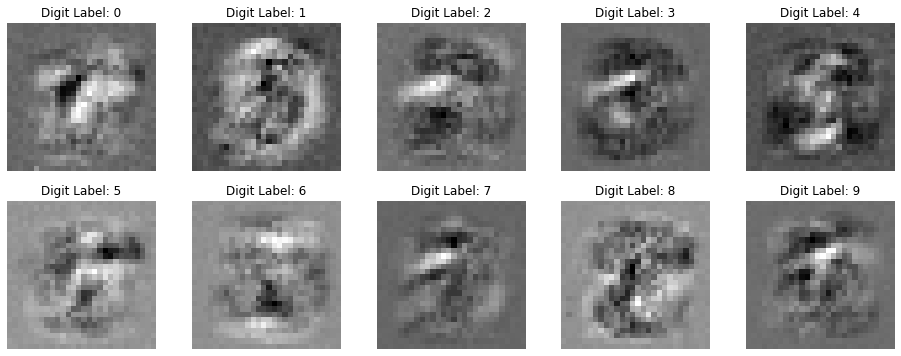

In [36]:
fig = plot_images_matplotlib(images=data, labels=targets, rows=2, cols=5)
path = os.path.join(base.DIR_IMAGES, datetime.now().strftime("%Y-%M-%d_%H-%M-%S")+'.png')
fig.savefig(path)
fig.show()

In [ ]:
# plot_images_plotly(images=data, labels=targets, rows=3, cols=4)

In [ ]:
data_hist = pd.DataFrame(data.reshape(-1, 28*28))
data_hist['target']=targets.cpu()
data_hist_melt = data_hist.melt(id_vars=['target'])
px.histogram(data_hist_melt, x='value', facet_col='target', height=400, width=1200)